In [11]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pprint

pp = pprint.PrettyPrinter(indent=4)

In [12]:
# filename = 'corner3.jpg'
filename = '4_avg.png'
folder = 'result_' + filename.split('.')[0] + '/'
if not os.path.isdir(folder):
    os.mkdir(folder)
img = cv2.imread(filename)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

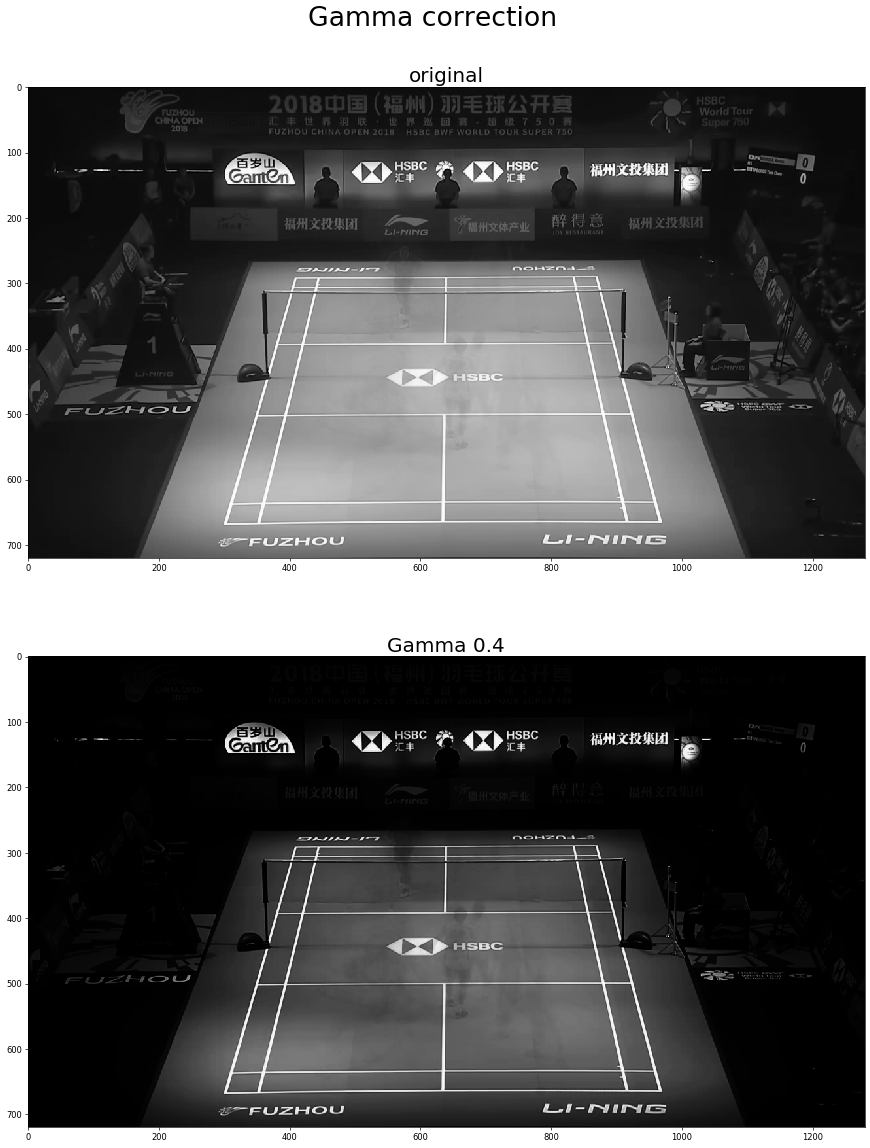

In [13]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table) # apply gamma correction using the lookup table

gamma = 0.4
fig , axs = plt.subplots(2, 1, figsize=(18, 24), dpi=60)
fig.subplots_adjust(hspace=0.1, wspace=0.1) #設定子圖的間隔
fig.suptitle('Gamma correction', y=0.92, fontsize=32)
g = adjust_gamma(gray, gamma)

axs[0].imshow(gray, cmap='gray')
axs[0].set_title('original', fontsize=24)
axs[1].imshow(g, cmap='gray')
axs[1].set_title('Gamma {}'.format(gamma), fontsize=24)
plt.show()

[[[ 60 255 255]]]


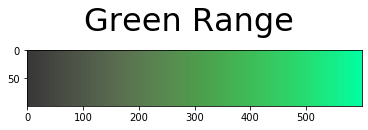

In [14]:
# generate green space
fig = plt.figure()
fig.suptitle('Green Range', y=0.75, fontsize=32)

green = np.uint8([[[0,255,0]]])
range1 = [20,255,200]
range2 = [20,0,0]
hsv_green = cv2.cvtColor(green, cv2.COLOR_BGR2HSV)
green_map = np.linspace(hsv_green.reshape(-1)-range1, hsv_green.reshape(-1)+range2, 600)
green_map = np.tile(np.expand_dims(green_map, axis=0), (100,1,1))
print(hsv_green)
plt.imshow(cv2.cvtColor(green_map.astype(np.uint8), cv2.COLOR_HSV2RGB))
plt.show()

(720, 1280)


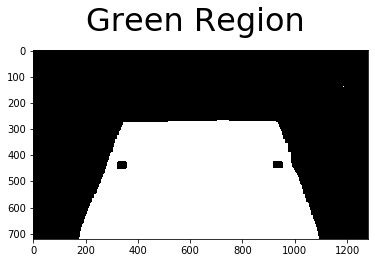

In [15]:
fig = plt.figure()
fig.suptitle('Green Region', fontsize=32)

# detect green region
iterations = 10
mask = cv2.inRange(hsv, hsv_green-range1, hsv_green+range2) > 0
print(mask.shape)
mask = cv2.erode(mask.astype(np.float32), None, iterations = 1)
mask = cv2.dilate(mask.astype(np.float32), None, iterations = iterations)
mask = cv2.erode(mask, None, iterations = iterations+2)
plt.imshow(mask, cmap='gray')
plt.show()
mask = mask > 0
mask = np.stack((mask,mask,mask), 2)

# Find Straight Lines

In [16]:
# line detect
kernel_size = 5

# sharpen
gray = adjust_gamma(gray, 0.4)
blur = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0).astype(int)
sub = gray.astype(int) - blur
sharped_img = np.clip(gray.astype(int) + sub*2, a_min = 0, a_max = 255).astype('uint8')

# sharped_gray = cv2.cvtColor(sharped_img, cv2.COLOR_BGR2GRAY)
low_threshold = 85
high_threshold = 85*3
edges = cv2.Canny(sharped_img, low_threshold, high_threshold, apertureSize=3)

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 30  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 75  # minimum number of pixels making up a line
max_line_gap = 5  # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

73 Lines


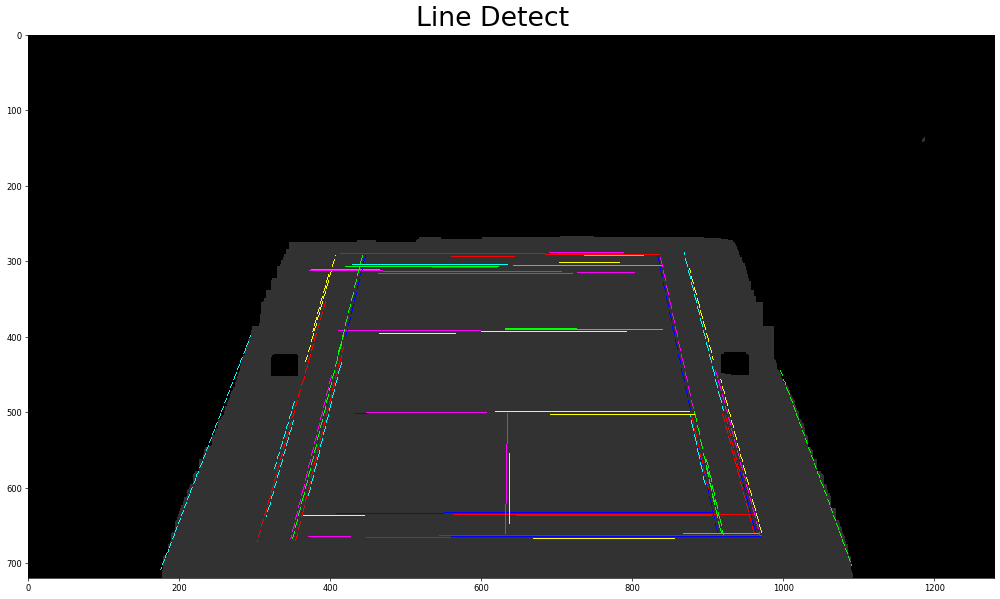

In [17]:
import random

fig = plt.figure(figsize=(24, 12), dpi=60)
fig.suptitle('Line Detect', y=0.92, fontsize=32)

m_lines = []
def interpolate(pt):
    x1,y1,x2,y2 = pt
    num = max(abs(x1-x2), abs(y1-y2))
    np.around(np.linspace(x1, x2+1, num=num+1))
    return np.stack((np.around(np.linspace(x1, x2, num=num+1)), np.around(np.linspace(y1, y2, num=num+1))), axis=1).astype(int)

# filter out lines
for line in lines.reshape(-1,4):
    # interpolate
    full_line = interpolate(line)
    check = mask[:, :,0][full_line[:,1], full_line[:,0]]
    if check.sum() >= len(check) * 0.5:
        m_lines.append(line)
        
print(len(m_lines), 'Lines')
tmp = np.zeros_like(img) + mask.astype('uint8')*50
for x1,y1,x2,y2 in m_lines:
    color = random.choice([(0,0,255), (0,255,0), (255,0,0), (0,255,255), (255,255,0), (255,0,255)])
    cv2.line(tmp,(x1,y1),(x2,y2),color,1)
        
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))
plt.show()

# Extend straight line

{0}
{1, 2, 3, 4, 5, 6}
slopes: [[1, 2.898906062414995], [2, 2.8910584920622364], [3, 2.8936708988950346], [4, 2.880644031439945], [5, 2.8832423152027697], [6, 2.879346238057545]]
newset: [[1, 2.898906062414995], [2, 2.8910584920622364], [3, 2.8936708988950346], [4, 2.880644031439945], [5, 2.8832423152027697], [6, 2.879346238057545]]
{7}
{8, 9, 10, 11, 12, 13, 14, 15}
slopes: [[8, 2.9292648703246407], [9, 2.927936197064069], [10, 2.9226292002880534], [11, 2.927936197064069], [12, 2.9332554434016305], [13, 2.927936197064069], [14, 2.9213043951315196], [15, 2.9160130693088786]]
newset: [[8, 2.9292648703246407], [9, 2.927936197064069], [10, 2.9226292002880534], [11, 2.927936197064069], [12, 2.9332554434016305], [13, 2.927936197064069], [14, 2.9213043951315196], [15, 2.9160130693088786]]
{16, 17}
slopes: [[16, 0.012516731556862615], [17, 3.141591653589793]]
newset: [[16, 0.012516731556862615], [17, 3.141591653589793]]
{18, 19, 20, 21, 22, 23}
slopes: [[18, 0.2400638927386054], [19, 0.241375

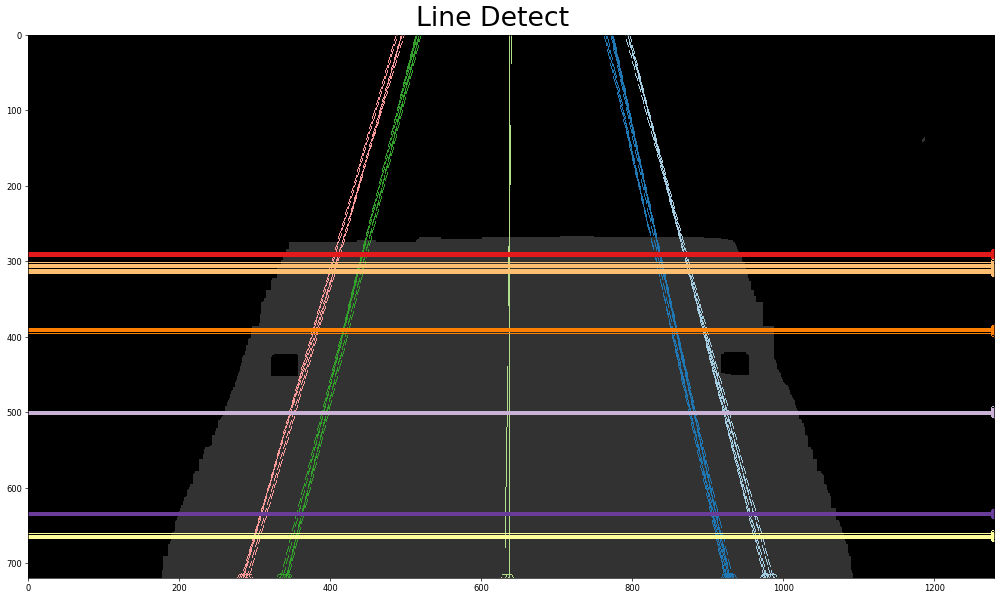

In [18]:
from utils import merge_lines, lines_clustering, find_edge, find_intersection, parse_color, filter_set, check_white
from math import sqrt
import colorbrewer

_h, _w, _ = img.shape
e_m_lines = []
for x1,y1,x2,y2 in m_lines:
    (e_x1,e_y1), (e_x2,e_y2) = find_edge(np.array([x1,y1]), np.array([x2,y2]), _h, _w)
    e_m_lines.append(np.array([e_x1,e_y1,e_x2,e_y2]))
e_m_lines.sort(key=lambda ele: ele[1])
idx_non_0 = next((index for index,value in enumerate(np.array(e_m_lines)[:,1].tolist()) if value != 0), None)
idx_is__h = next((index for index,value in enumerate(np.array(e_m_lines)[:,1].tolist()) if value == _h-1), None)
e_m_lines[:idx_non_0] = sorted(e_m_lines[:idx_non_0], key=lambda ele: -ele[0])
if idx_is__h != None:
    e_m_lines[idx_is__h:] = sorted(e_m_lines[idx_is__h:], key=lambda ele: ele[0])

e_m_lines = merge_lines(e_m_lines)
# only keep the set that has more than one line
line_set = [i for i in lines_clustering(e_m_lines, threshold=8) if len(i)>1 and check_white(hsv, e_m_lines, i)]
print(len(line_set))

fig = plt.figure(figsize=(24, 12), dpi=60)
fig.suptitle('Line Detect', y=0.92, fontsize=32)

colors = colorbrewer.qualitative["Paired"][min(len(line_set),12)]
tmp_2 = np.zeros_like(img) + mask.astype('uint8')*50
for sid, l_set in enumerate(line_set):
    for line_id in l_set:
        x1,y1,x2,y2 = e_m_lines[line_id]
        try:
            color = parse_color(colors[sid%12])
        except IndexError:
            color = (255,255,255)
        cv2.line(tmp_2,(x1,y1),(x2,y2),color,1)
        cv2.circle(tmp_2, (x2,y2), 5, color)
    cv2.imwrite(folder+'colorful_set{}.png'.format(sid), tmp_2)
cv2.imwrite(folder+'colorful.png', tmp_2)
        
fake_sets = filter_set(e_m_lines, line_set, _h, _w)
tmp_2_f = np.zeros_like(img) + mask.astype('uint8')*50
for sid, l_set in enumerate(fake_sets):
    for x1,y1,x2,y2 in l_set:
        try:
            color = parse_color(colors[sid%12])
        except IndexError:
            color = (255,255,255)
        cv2.line(tmp_2_f,(x1,y1),(x2,y2),color,1)
    cv2.imwrite(folder+'colorful_fake_set{}.png'.format(sid), tmp_2_f)
cv2.imwrite(folder+'colorful_f.png', tmp_2_f)
        
plt.imshow(cv2.cvtColor(tmp_2, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
stand = [sublist[0] for sublist in fake_sets]
pp.pprint(stand)
inter = np.zeros((len(stand),len(stand),2), 'int')
for i,l1 in enumerate(stand):
    for j,l2 in enumerate(stand):
        if i>=j: continue
        inter[i,j] = np.clip(np.array(find_intersection(l1,l2)), -2000000000, 2000000000)
np.set_printoptions(suppress=True)
# pp.pprint(inter[...,0])
# pp.pprint(inter[...,1])
intergroup = list()
intergroup.append({(0,1)})
for i in range(len(stand)):
    for j in range(len(stand)):
        if i>=j: continue
        new_group = True
        for si,seti in enumerate(intergroup):
            same_group = True
            for ele in seti:
                if np.linalg.norm(inter[i,j] - inter[ele]) > 100: #TODO Looserfor4avg rulebasefor5avgand6avg
                    same_group = False
                    break
            if same_group:
                intergroup[si].add((i,j))
                new_group = False
                break
        if new_group:
            intergroup.append({(i,j)})
intergroup.sort(key = lambda ele: -len(ele))
SET1 = set([ggg for gg in intergroup[0] for ggg in gg])
SET2 = set([ggg for gg in intergroup[1] for ggg in gg])
print('SET:', SET1)
print('SET:', SET2)

[   array([796,   0, 986, 719]),
    array([774,   0, 932, 719]),
    array([640,   0, 637, 719]),
    array([520,   0, 344, 719]),
    array([498,   0, 292, 719]),
    array([   0,  289, 1279,  289]),
    array([   0,  302, 1279,  302]),
    array([   0,  389, 1279,  389]),
    array([   0,  497, 1279,  497]),
    array([   0,  633, 1279,  633]),
    array([   0,  661, 1279,  661])]
SET: {5, 6, 7, 8, 9, 10}
SET: {0, 1, 2, 3, 4}


[(0, 1, 2, 3, 4)]
{(5, 9), (6, 10), (5, 10)}
{(0, 4)}
new winner:
(5, 9) (0, 4) count 190785/190785, 100.00, good
new winner:
(6, 10) (0, 4) count 203040/203040, 100.00, good
new winner:
(5, 10) (0, 4) count 209066/209066, 100.00, good


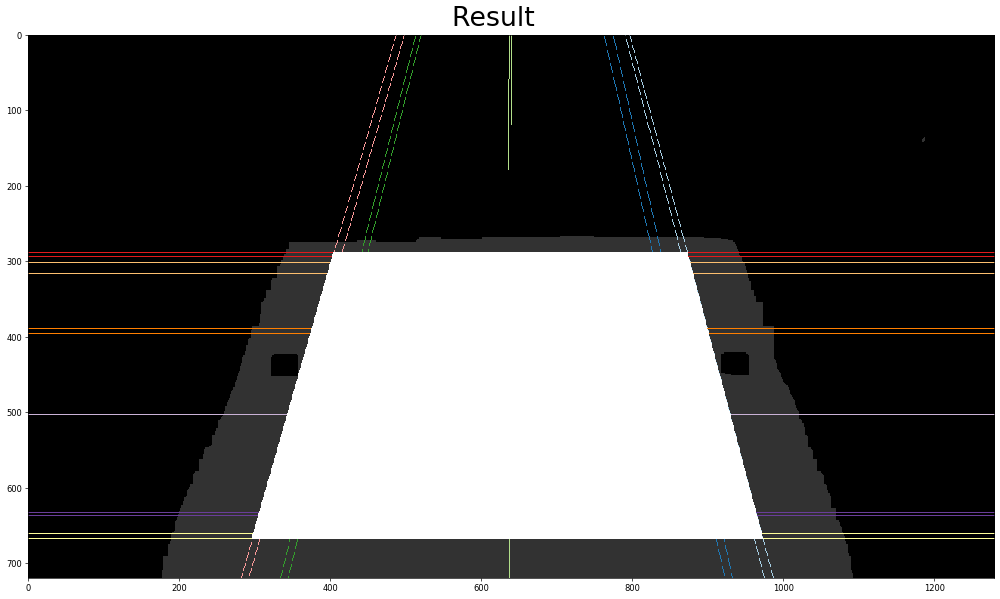

In [20]:
import itertools 
choose1 = list(itertools.combinations(SET1,5)) + list(itertools.combinations(SET1,6))
choose2 = list(itertools.combinations(SET2,5)) + list(itertools.combinations(SET2,6))
pp.pprint(choose2)

print(set([(i[0], i[-1]) for i in choose1]))
print(set([(i[0], i[-1]) for i in choose2]))
cand = 0
maxwin = 0
for l1,l2 in set([(i[0], i[-1]) for i in choose1]):
    for l3,l4 in set([(i[0], i[-1]) for i in choose2]):
        p1 = np.array(find_intersection(stand[l1],stand[l3]))
        p2 = np.array(find_intersection(stand[l2],stand[l3]))
        p3 = np.array(find_intersection(stand[l2],stand[l4]))
        p4 = np.array(find_intersection(stand[l1],stand[l4]))
        pts = np.array([[p1,p2,p3,p4]]).astype('int32')
        test = np.copy(tmp_2_f)
        color = (255,255,255)
        test = cv2.fillPoly(test, pts, color)
        cv2.imwrite(folder+'cand_{}.png'.format(cand), test)
        cand += 1
        test = np.zeros((_h,_w), 'uint8')
        test = cv2.fillPoly(test, pts, (1, 1, 1)).astype(bool)
        if np.logical_and(mask[...,0], test).sum() > maxwin and np.logical_and(mask[...,0], test).sum()*100/test.sum() > 80:
            print('new winner:')
            maxwin = np.logical_and(mask[...,0], test).sum()
            best = ((l1,l2),(l3,l4))
        print('{} {} count {}/{}, {:.2f}, {}'.format((l1,l2),
                                                     (l3,l4),
                                                     np.logical_and(mask[...,0], test).sum(), 
                                                     test.sum(), 
                                                     np.logical_and(mask[...,0], test).sum()*100/test.sum(),
                                                     '' if np.logical_and(mask[...,0], test).sum()*100/test.sum() < 80 else 'good'))
#         cv2.imshow('test', test.astype('uint8')*255)
#         cv2.waitKey(0)
cv2.destroyAllWindows()

((l1,l2),(l3,l4)) = best
p1 = np.array(find_intersection(fake_sets[l1][0],fake_sets[l3][0]))
p2 = np.array(find_intersection(fake_sets[l2][1],fake_sets[l3][0]))
p3 = np.array(find_intersection(fake_sets[l2][1],fake_sets[l4][1]))
p4 = np.array(find_intersection(fake_sets[l1][0],fake_sets[l4][1]))
pts = np.array([[p1,p2,p3,p4]]).astype('int32')
test = np.copy(tmp_2_f)
color = (255,255,255)
test = cv2.fillPoly(test, pts, color)
cv2.imwrite(folder+'court_result.png', test)


fig = plt.figure(figsize=(24, 12), dpi=60)
fig.suptitle('Result', y=0.92, fontsize=32)

plt.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
plt.show()